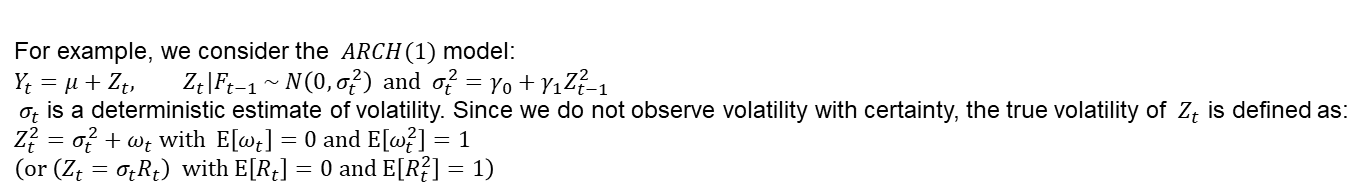

In [9]:
## Simulation: Independent vs Uncorrelated TS

a0 = 0.2
a1 = 0.5
R = rnorm(5000)
eps = rep(0, 5000)
sigsq = rep(0, 5000)
for (i in 2:5000)
{
   sigsq[i] = a0 + a1 * (eps[i-1]^2)
   eps[i] = sqrt(sigsq[i])*R[i]
 }

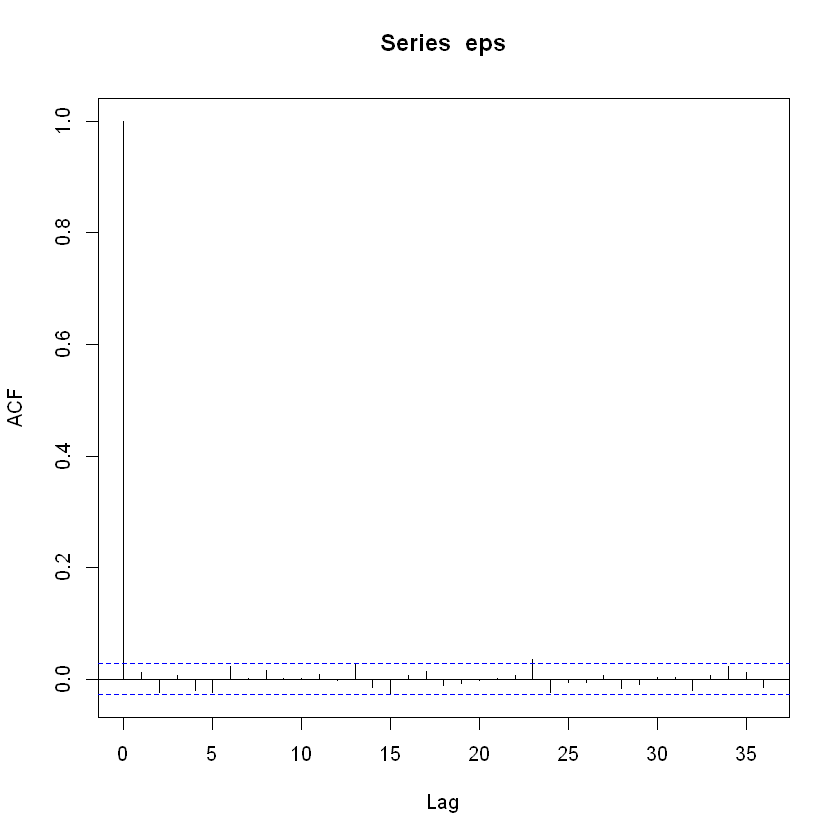

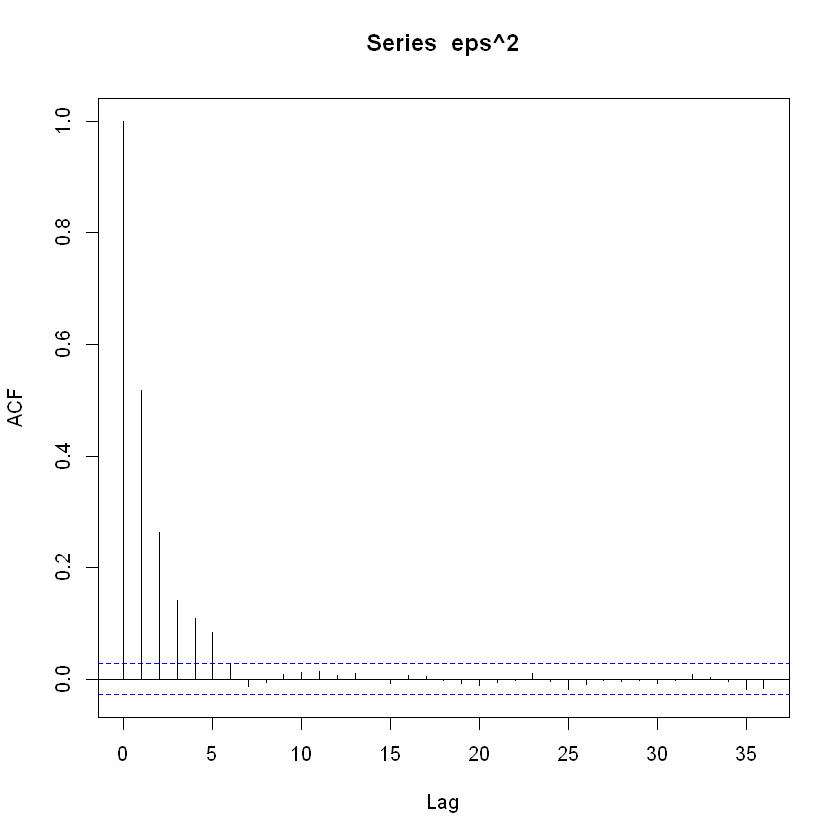

In [10]:
## Plot the acf of the time series and squared time series
acf(eps)
acf(eps^2)

Uncorrelated data but not independent (since squares are correlated). Note correlation measures for linearity!  

## Data example

Warning message:
"package 'quantmod' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Warning message:
"package 'TTR' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warn

[1] "PDCE"

           PDCE.Open PDCE.High PDCE.Low PDCE.Close PDCE.Volume PDCE.Adjusted
2007-01-03     42.99     43.34    42.81      43.02      161100         43.02

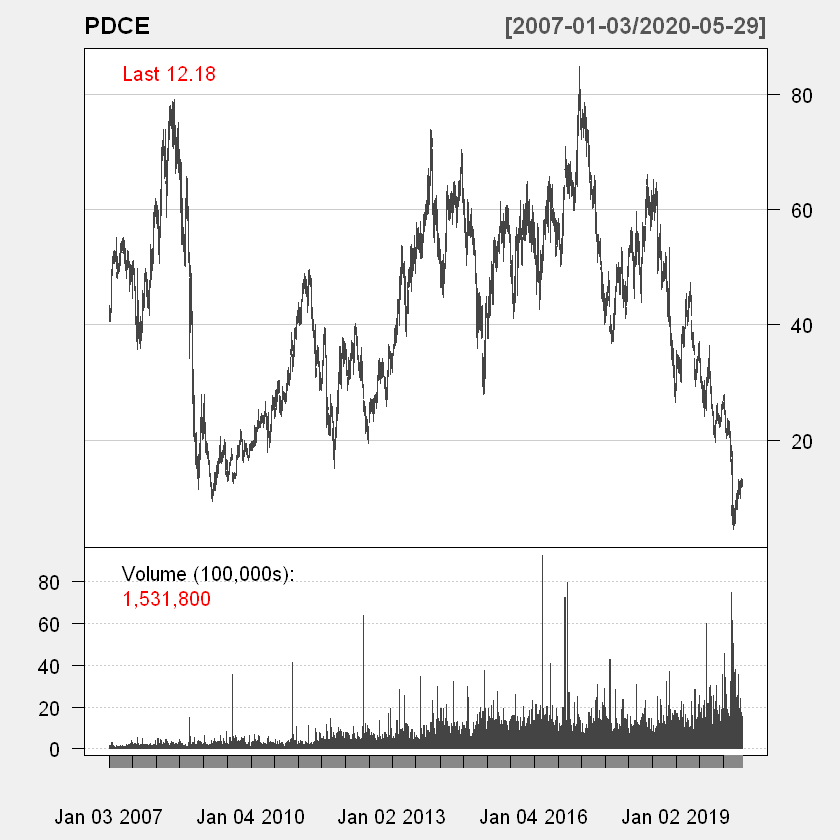

In [1]:
## Financial Data Analysis
library(quantmod)
## Get the daily traiding data for PDCE
getSymbols("PDCE",src="yahoo")
## What does the matrix PDCE include?
PDCE[1,]
candleChart(PDCE,multi.col=TRUE,theme="white")

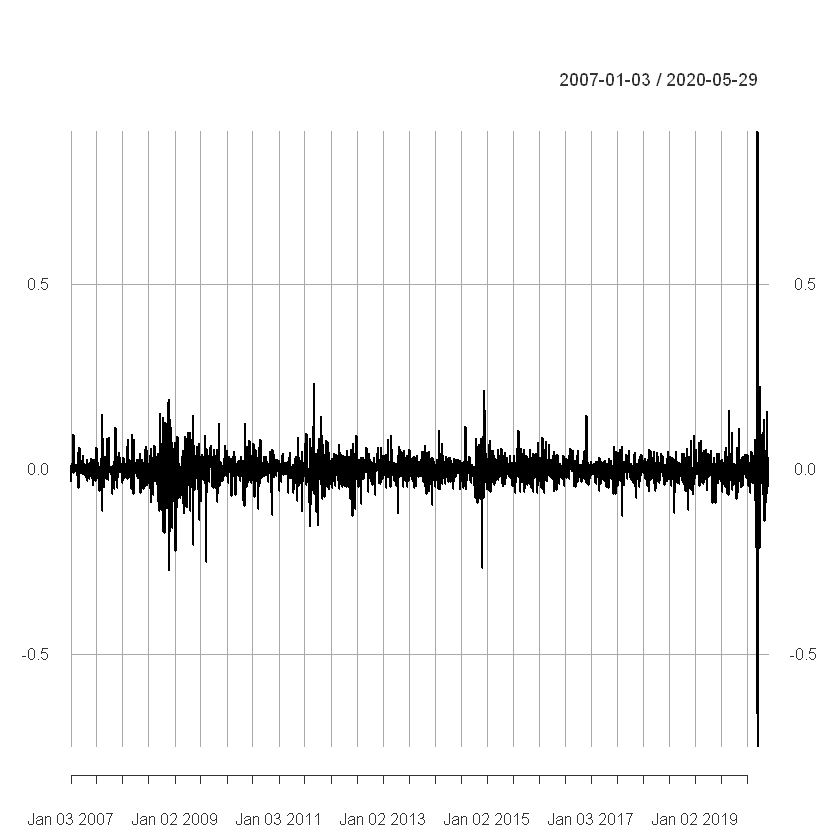

In [2]:
## Log returns of the close price
pdcert = diff(log(Cl(PDCE)))
plot(pdcert,main="")

In [ ]:
###############################################################################
## Fit ARIMA
final.aic = Inf
final.order = c(0,0,0)
for (p in 1:6) for (d in 0:1) for (q in 1:6) {
   current.aic = AIC(arima(pdcert, order=c(p, d, q)))
   if (current.aic < final.aic) {
     final.aic = current.aic
     final.order = c(p, d, q)
     final.arima = arima(pdcert, order=final.order)
   }
 }

In [3]:
# we get final.order=c(5,0,6)
final.arima = arima(pdcert, order=c(5,0,6))

Warning message in arima(pdcert, order = c(5, 0, 6)):
"possible convergence problem: optim gave code = 1"

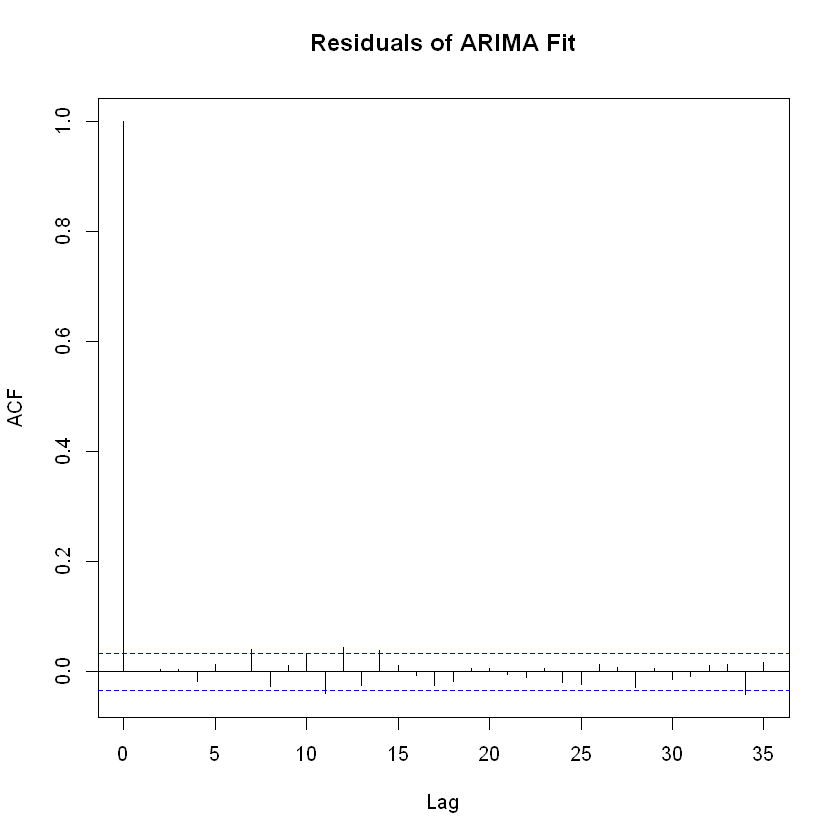

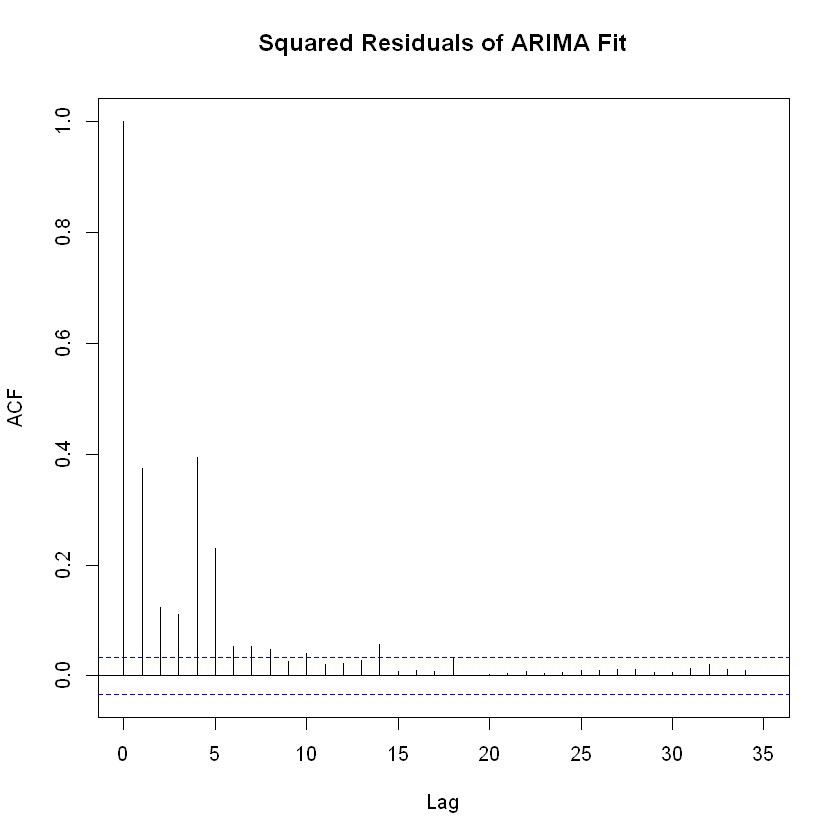

In [4]:
## Residual Analysis
resids = resid(final.arima)[-1]
acf(resids,main="Residuals of ARIMA Fit")
acf(resids^2,main="Squared Residuals of ARIMA Fit")

No correlation but not independent.

In [ ]:
# for serial correlation
Box.test((resids)^2,lag=12,type='Ljung',fitdf=11)
# for arch effect
Box.test(resids,lag=12,type='Ljung',fitdf=11)

We have evidence for ACFs of both resid and resid^2 series to be not normal (ie correlated)

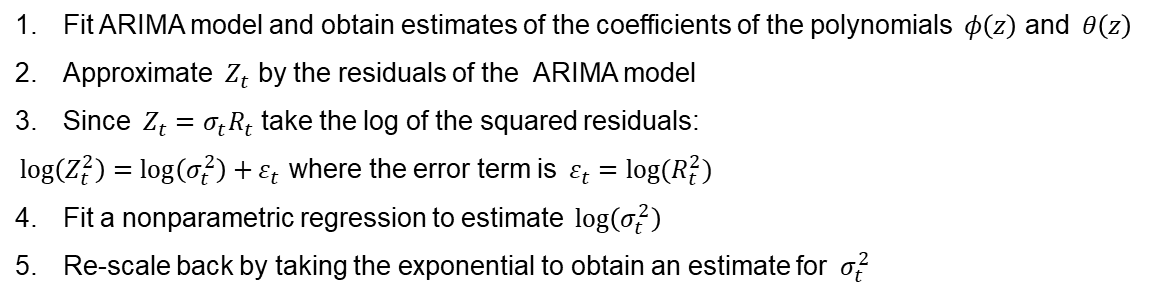

Warning message:
"package 'mgcv' was built under R version 3.6.3"Loading required package: nlme
Warning message:
"package 'nlme' was built under R version 3.6.3"This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.


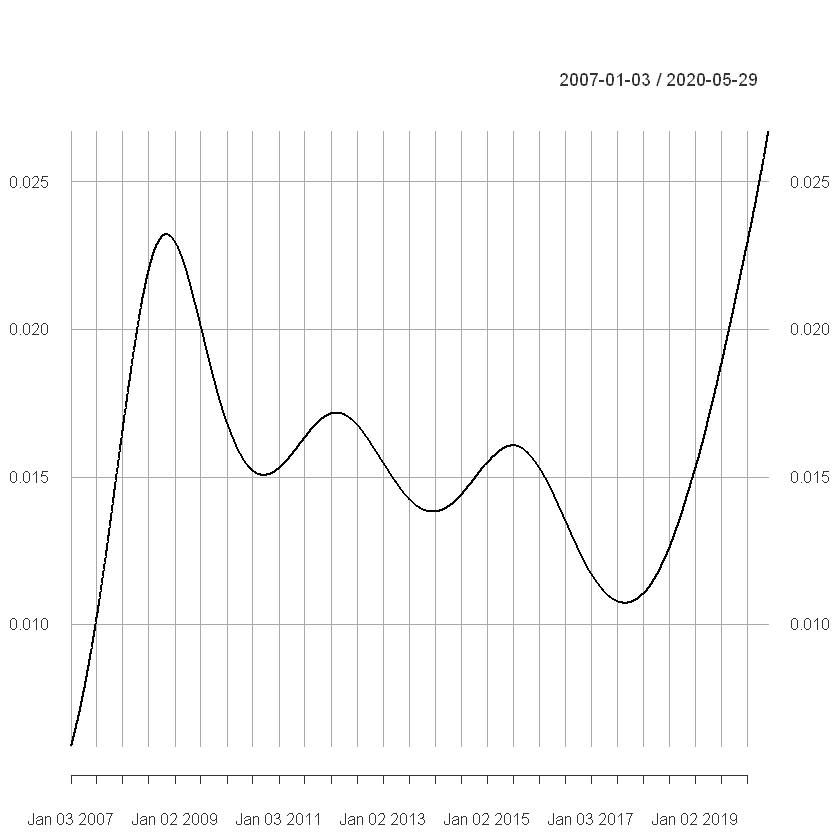

In [5]:
## Estimate the variance using nonparametric regression 
library(mgcv)
zt.sq.log = log(resids^2)
n = length(resids)
time.pts = c(1:n)
time.pts = (time.pts-min(time.pts))/(max(time.pts)-min(time.pts))
gam.var = gam(zt.sq.log~s(time.pts))
pdcert.obs = pdcert[-1]
pdcert$PDCE.Close[-1]=sqrt(exp(fitted(gam.var)))
pdcert.var.fit=pdcert
plot(pdcert.var.fit,main="")

Warning message:
"package 'tseries' was built under R version 3.6.3"

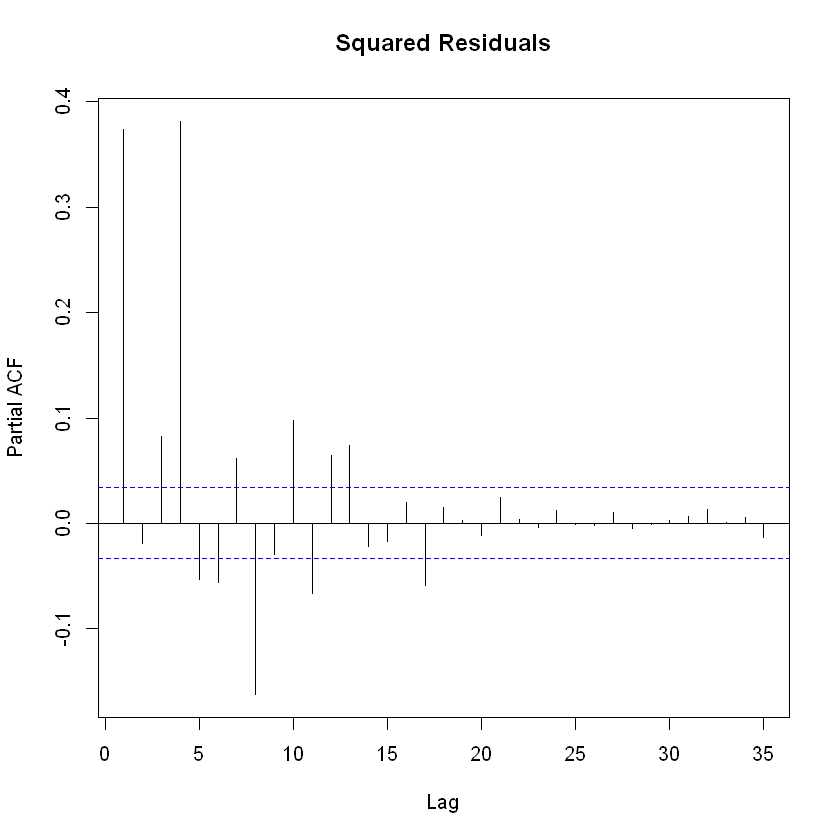

In [7]:
library(tseries)
pacf(resids^2,main="Squared Residuals")

## Fit a ARCH(7) on residuals from ARMA

In [15]:
garch.fit = garch(resids, order = c(0, 7),trace=F)
summary(garch.fit)


Call:
garch(x = resids, order = c(0, 7), trace = F)

Model:
GARCH(0,7)

Residuals:
     Min       1Q   Median       3Q      Max 
-6.66616 -0.54392  0.02472  0.57554  4.82776 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 3.882e-04   2.113e-05   18.375  < 2e-16 ***
a1 2.231e-01   1.213e-02   18.392  < 2e-16 ***
a2 1.017e-01   1.722e-02    5.908 3.45e-09 ***
a3 8.736e-02   1.586e-02    5.509 3.61e-08 ***
a4 1.338e-01   1.622e-02    8.247 2.22e-16 ***
a5 4.586e-02   1.012e-02    4.531 5.86e-06 ***
a6 1.421e-01   1.175e-02   12.092  < 2e-16 ***
a7 5.535e-02   1.268e-02    4.367 1.26e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 1186.9, df = 2, p-value < 2.2e-16


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.027765, df = 1, p-value = 0.8677


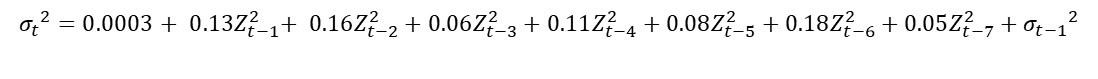
Note the figures wont match as now we include more time series data of stock from yahoo than was in the slides.

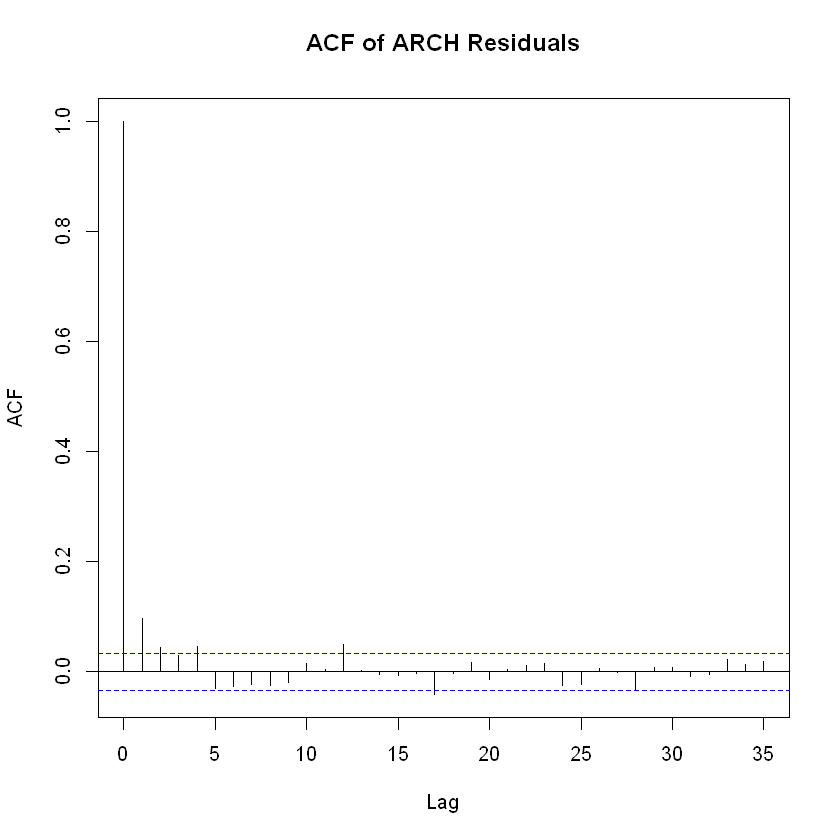

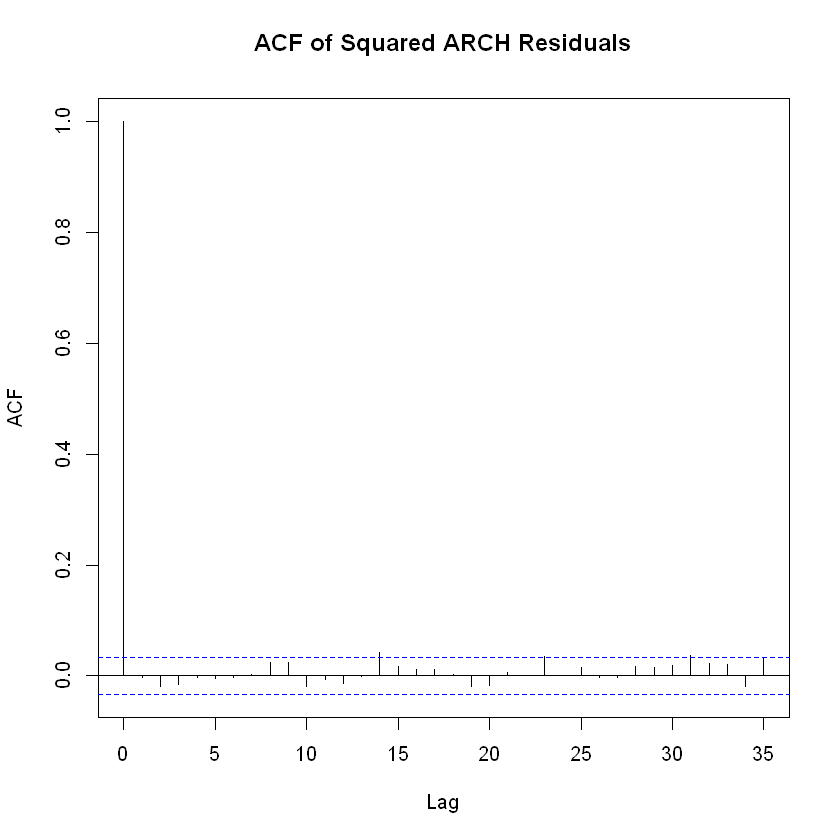

In [16]:
#remove first 7 residuals as they are NA
## Evaluate goodness of fit
resids.fgarch = residuals(garch.fit)[-c(1:7)]
acf(resids.fgarch,main="ACF of ARCH Residuals")
acf(resids.fgarch^2,main="ACF of Squared ARCH Residuals")

In [17]:
Box.test(resids.fgarch,lag=8,type='Ljung',fitdf=7)
Box.test(resids.fgarch^2,lag=8,type='Ljung',fitdf=7)


	Box-Ljung test

data:  resids.fgarch
X-squared = 58.002, df = 1, p-value = 2.62e-14



	Box-Ljung test

data:  resids.fgarch^2
X-squared = 4.2884, df = 1, p-value = 0.03837


Small meaning very less autocorrelation present in both series.

# Compare step-wise ARMA+ARCH and simultaneous ARMA-ARCH

In [20]:
## garchFit from the fGarch library
library(fGarch)
## Fit ARCH on the ARMA residuals (stepwise as seen earlier)
archFit.resid = garchFit(~ garch(7,0), data = resids, trace = FALSE)
summary(archFit.resid)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(7, 0), data = resids, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(7, 0)
<environment: 0x0000000005586e08>
 [data = resids]

Conditional Distribution:
 norm 

Coefficient(s):
        mu       omega      alpha1      alpha2      alpha3      alpha4  
3.7053e-05  3.8942e-04  2.2196e-01  1.0104e-01  8.7082e-02  1.3298e-01  
    alpha5      alpha6      alpha7  
4.5605e-02  1.4149e-01  5.5075e-02  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     3.705e-05   5.170e-04    0.072 0.942867    
omega  3.894e-04   2.845e-05   13.689  < 2e-16 ***
alpha1 2.220e-01   2.841e-02    7.813 5.55e-15 ***
alpha2 1.010e-01   2.324e-02    4.348 1.37e-05 ***
alpha3 8.708e-02   2.354e-02    3.700 0.000216 ***
alpha4 1.330e-01   2.349e-02    5.662 1.49e-08 ***
alpha5 4.560e-02   1.905e-02    2.394 0.016683 *  
alpha6 1.415e-01   2.219e-02    6.377 1.80e-10 ***
alpha7 5.508e-02   1.8

In [25]:
## Fit simultaneous ARMA-ARCH 
archFit.ts = garchFit(~ arma(5,6)+ garch(7,0), data=pdcert[-1], trace = FALSE)
summary(archFit.ts)

ERROR: Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE, : non-finite finite-difference value [5]


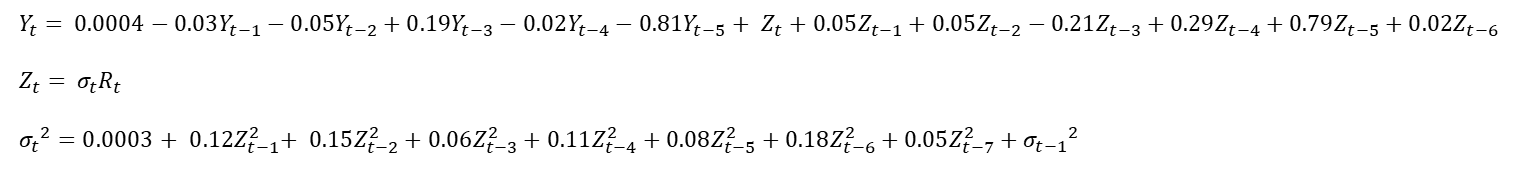

The estimated  ARMA coefficients from the ARMA-ARCH fit are different from the estimated coefficients from ARMA fit alone.

# GARCH

In [26]:
######## Apply GARCH Model #############################################
##divide into training and testing
## Predict July & August 
pdcert = pdcert[-1]
n=length(pdcert)
pdcert.test = pdcert[2643:n]
pdcert.train =  pdcert[-c(2643:n)]

In [30]:
library(rugarch)
### Goodness of Fit ####################################################
spec.1 = ugarchspec(variance.model=list(garchOrder=c(1,2)),
                 mean.model=list(armaOrder=c(5, 6), 
                 include.mean=T), distribution.model="std")    
final.model.1 = ugarchfit(spec.1, pdcert.train, solver = 'hybrid')

spec.2 = ugarchspec(variance.model=list(garchOrder=c(1,2)),
                 mean.model=list(armaOrder=c(0, 0), 
                 include.mean=T), distribution.model="std")    
final.model.2 = ugarchfit(spec.2, pdcert.train, solver = 'hybrid')

spec.3 = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                 mean.model=list(armaOrder=c(0, 0), 
                 include.mean=T), distribution.model="std")    
final.model.3 = ugarchfit(spec.3, pdcert.train, solver = 'hybrid')


Warning message:
"package 'rugarch' was built under R version 3.6.3"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"

,
Akaike,-30.26852
Bayes,-30.23069
Shibata,-30.26861
Hannan-Quinn,-30.25483


,
Akaike,-10.28113
Bayes,-10.26778
Shibata,-10.28114
Hannan-Quinn,-10.27630


,
Akaike,-10.26118
Bayes,-10.25006
Shibata,-10.26119
Hannan-Quinn,-10.25716


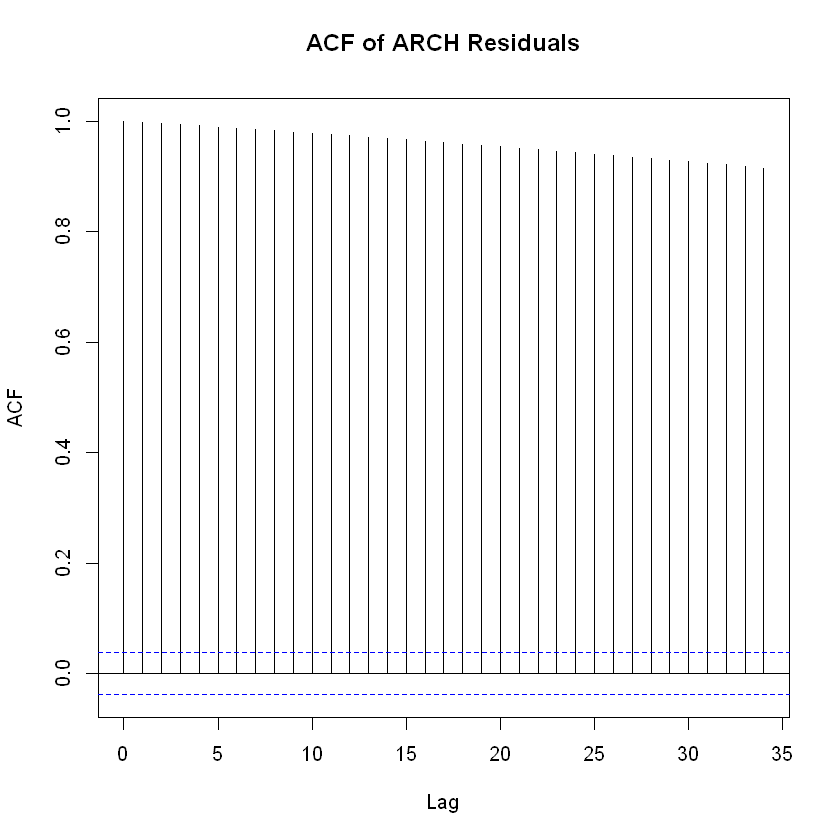


	Box-Ljung test

data:  resids.final.model
X-squared = 25875, df = 10, p-value < 2.2e-16



	Box-Ljung test

data:  resids.final.model^2
X-squared = 25621, df = 10, p-value < 2.2e-16


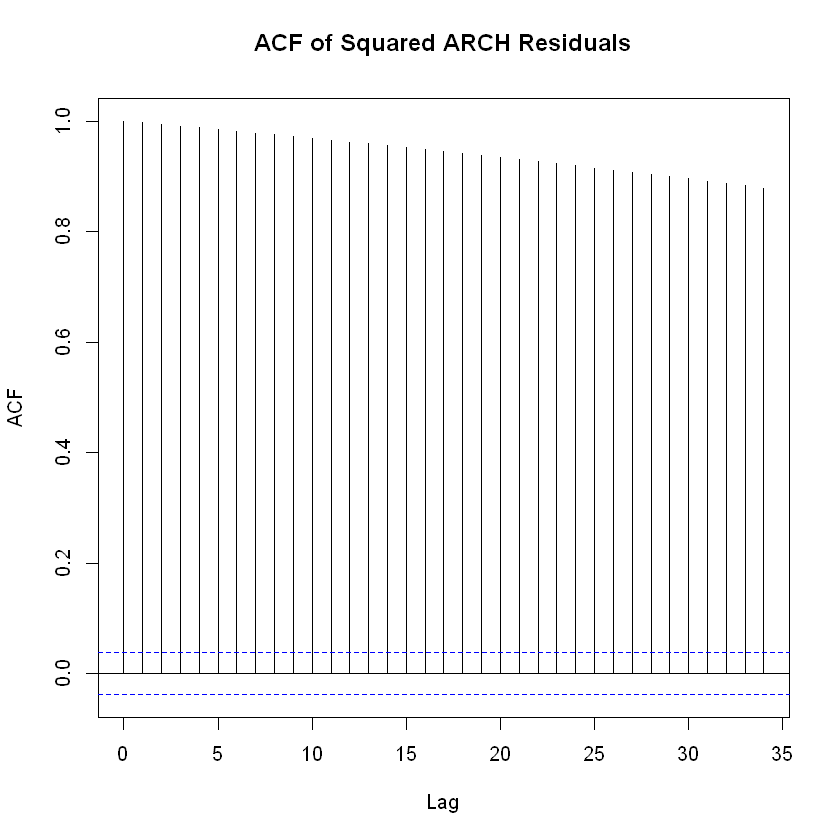

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
"
rugarch-->warning: failed to invert hessian
"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
"
rugarch-->warning: failed to invert hessian
"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence

"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
"
rugarch-->warning: failed to invert hessian
"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
"
rugarch-->warning: failed to invert hessian
"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
"
rugarch-->warning: failed to invert hessian
"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = mo

In [ ]:
## compare Information Criteria
infocriteria(final.model.1)
infocriteria(final.model.2)
infocriteria(final.model.3)

## Residual Analysis 
resids.final.model = residuals(final.model.3)
acf(resids.final.model,main="ACF of ARCH Residuals")
acf(resids.final.model^2,main="ACF of Squared ARCH Residuals")                    
Box.test(resids.final.model,lag=10,type='Ljung')
Box.test(resids.final.model^2,lag=10,type='Ljung')
qqnorm(resids.final.model)

### Prediction ##################################################

## 1. Prediction of the return time series
## 2. Prediction of the volatility 
nfore = length(pdcert.test)
fore.series.1 = NULL
fore.sigma.1 = NULL
fore.series.2 = NULL
fore.sigma.2 = NULL
fore.series.3 = NULL
fore.sigma.3 = NULL
for(f in 1: nfore){
    ## Fit models
    data = pdcert.train
    if(f>2)
       data = c(pdcert.train,pdcert.test[1:(f-1)])  
    final.model.1 = ugarchfit(spec.1, data, solver = 'hybrid')    
    final.model.2 = ugarchfit(spec.2, data, solver = 'hybrid')
    final.model.3 = ugarchfit(spec.3, data, solver = 'hybrid')
    ## Forecast
    fore = ugarchforecast(final.model.1, n.ahead=1)
    fore.series.1 = c(fore.series.1, fore@forecast$seriesFor)
    fore.sigma.1 = c(fore.sigma.1, fore@forecast$sigmaFor)
    fore = ugarchforecast(final.model.2, n.ahead=1)
    fore.series.2 = c(fore.series.2, fore@forecast$seriesFor)
    fore.sigma.2 = c(fore.sigma.2, fore@forecast$sigmaFor)
    fore = ugarchforecast(final.model.3, n.ahead=1)
    fore.series.3 = c(fore.series.3, fore@forecast$seriesFor)
    fore.sigma.3 = c(fore.sigma.3, fore@forecast$sigmaFor)
    }
 
 ## Compute Accuracy Measures 

### Mean Squared Prediction Error (MSPE)
mean((fore.series.1 - pdcert.test)^2)
mean((fore.series.2 - pdcert.test)^2)
mean((fore.series.3 - pdcert.test)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(fore.series.1 - pdcert.test))
mean(abs(fore.series.2 - pdcert.test))
mean(abs(fore.series.3 - pdcert.test))
### Mean Absolute Percentage Error (MAPE)
mean(abs(fore.series.1 - pdcert.test)/pdcert.test)
mean(abs(fore.series.2 - pdcert.test)/pdcert.test)
mean(abs(fore.series.3 - pdcert.test)/pdcert.test)
### Precision Measure (PM)
sum((fore.series.1 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)
sum((fore.series.2 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)
sum((fore.series.3 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)   

ymin = min(c(as.vector(pdcert.test),fore.series.1,fore.series.2,fore.series.3))
ymax = max(c(as.vector(pdcert.test),fore.series.1,fore.series.2,fore.series.3))
data.plot = pdcert.test
names(data.plot)="Fore"
plot(pdcert[c(n-90):n],type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Return Price")
data.plot$Fore=fore.series.1
points(data.plot,lwd= 2, col="blue")
data.plot$Fore=fore.series.2
points(data.plot,lwd= 2, col="brown")
data.plot$Fore=fore.series.3
points(data.plot,lwd= 2, col="purple")

ymin = min(c(as.vector(pdcert.test^2),fore.sigma.1^2,fore.sigma.2^2,fore.sigma.3^2))
ymax = max(c(as.vector(pdcert.test^2),fore.sigma.1^2,fore.sigma.2^2,fore.sigma.3^2))

plot(pdcert[c(n-90):n]^2,type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Return Price")
data.plot$Fore=fore.sigma.1^2
points(data.plot,lwd= 2, col="blue")
data.plot$Fore=fore.sigma.2^2
points(data.plot,lwd= 2, col="brown")
data.plot$Fore=fore.sigma.3^2
points(data.plot,lwd= 2, col="purple")